# Cartpole cross-entropy

Policy-based learning. Basic method:

* Play n episodes using current model and environment
* Calculate total reward for each episode
* Keep best episodes (e.g. top 50%)
* Train on remaining episodes using observations and actions taken
* Repeat

## Import modules and set up variables

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
DISPLAY_GAME = False
LEARNING_RATE = 0.003

## Check for GPU (cuda)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


## The cross-entropy neural net

In [4]:
class Net(nn.Module):
    """
    Pytorch neural net using the flexible pytorch nn.Modlule class.
    Note: the neural net output is linear. To convert these to probabilities for
    each action (the sam to 1.0) a SoftMax activation is required, but this is
    applied outside of the net itslef, which improves speed and stability of 
    training.
    """
    
    def __init__(self, observation_space, action_space):
        """Define layers of sequential net"""
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, action_space),
    )

    def forward(self, x):
        """Define forward pass (simple, as using a pre-defined sequential
        model)"""
        return self.net(x)

## Function to filter best episodes

In [5]:
def filter_episodes(results, percentile_cutoff = 70):
    """Get best episodes"""
    
    # Get episode rewards & define cuttoff
    episode_rewards = [episode['episode_reward'] for episode in results]
    reward_cutoff = np.percentile(episode_rewards, percentile_cutoff)
    
    # Get best episode observations and actions
    obs = [episode['episode_obs'] for episode in results if 
           episode['episode_reward'] >= reward_cutoff]
    
    actions = [episode['episode_actions'] for episode in results if 
               episode['episode_reward'] >= reward_cutoff]
    

    # Convert list of observation arrays into a numpy array
    obs = np.vstack(obs)
    
    # Flatten actions list and convert to NumPy
    actions = [item for sublist in actions for item in sublist]
    actions = np.array(actions)    
 
    return obs, actions

## Function to play an episode

In [6]:
def play_episode(env, model, observation_space):
    """Play an episode"""
    
    # Define softmax layer
    sm = nn.Softmax(dim=1)  
    
    # Reset trackers and environment
    episode_reward = 0
    obs_tracker = []
    action_tracker = []

    # Reset environment (returns first observation)
    obs = env.reset()
    
    # Loop up to 200 steps
    for step in range(200):
        
        # Show game step
        if DISPLAY_GAME:
            env.render()
            
        # Track observations
        obs = np.float32(obs)
        obs_tracker.append(obs)
        
        # Get action probability (put obs in Tensor first)
        obs = torch.FloatTensor([obs]).to(device)
        act_probs = model(obs)
        act_probs = sm(act_probs)
        act_probs = act_probs.cpu().data.numpy()[0]
        
        # Get and track action
        action = np.random.choice(len(act_probs), p=act_probs)
        action_tracker.append(action)
        
        # Take action
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        
        # Pole has fallen over if done is True
        if done:
            break
     
    # Put results in dictionary
    results = {'episode_reward': episode_reward,
               'episode_obs': obs_tracker,
               'episode_actions': action_tracker}

    return results

## Function to plot results

In [7]:
def plot_results(batch, average, best):
    """Line plot of average and best rewards over time"""
    
    plt.plot(batch, average, label='Average batch reward')
    plt.plot(batch, best, label='Best batch reward')
    plt.xlabel('Batch')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [8]:
def main():
    
    # Set number of episodes to play before slecting best and updating net
    episode_batch_size = 10
    
    # Set up environment
    env = gym.make("CartPole-v0")
    
    # Get number of observations from environemt(allows the env to change)
    obs_size = env.observation_space.shape[0]
    
    # Get number of actins from environemnt
    n_actions = env.action_space.n
    
    # Set up Neural Net
    model = Net(obs_size, n_actions).to(device)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    # Play batches of episodes 
    batch_count = 0
    
    # Lists to store results
    all_results_batch_number = []
    all_results_average_reward = []
    all_results_maxumum_reward = []
    
    # Continue until goal performance reached
    while True:
        
        # Play episodes 
        batch_count += 1
        episode_batch_results = []
        for episode in range(episode_batch_size):
            results = play_episode(env, model, obs_size)
            episode_batch_results.append(results)
            
        # Get average and maximum reward
        rewards = [episode['episode_reward'] for episode in 
                   episode_batch_results]
        average_reward = np.mean(rewards)
        maximum_reward = np.max(rewards)
        
        # Store results
        all_results_batch_number.append(batch_count)
        all_results_average_reward.append(average_reward)
        all_results_maxumum_reward.append(maximum_reward)
        
        print ('\rBatch {0:3}. Average and best run: {1:3.0f}, {2:3.0f}'.format(
            batch_count, average_reward, maximum_reward), end="")
        
        # Check whether goal reached (and break loop)
        if average_reward >= 190:
            print ('\nGoal achieved')
            break
        
        # Get best runs
        training_obs, training_actions = filter_episodes(episode_batch_results)  
        training_obs = torch.Tensor(training_obs).to(device)
        training_actions = torch.Tensor(training_actions).long().to(device)
        
        # Train model
        optimizer.zero_grad()
        action_scores = model(training_obs)
        loss_v = objective(action_scores, training_actions)
        loss_v.backward()
        optimizer.step()
        
            
    # Plot results
    plot_results(all_results_batch_number, all_results_average_reward, 
                 all_results_maxumum_reward)

Batch 129. Average and best run: 192, 200
Goal achieved


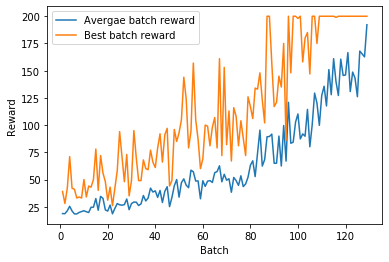

In [9]:
if __name__ == '__main__':
    main()